In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
import seaborn as sns

from supervised_sentiment_analysis import *
from constants import *
from utilities import *

In [2]:
merged_results = pickle.load(open('merged_results.P', 'rb'))
merged_results['Valid Vector'] = merged_results['Skip Thought Vector'].apply(lambda x: ~np.isnan(x).any())
removed_results = merged_results[~merged_results['Valid Vector']]
merged_results = merged_results[merged_results['Valid Vector']]
labeled_results = merged_results[merged_results['Categorical Tag'] != 'no tag']
q1_results = merged_results[merged_results['Question'] == Q1]
q1_labeled_results = labeled_results[labeled_results['Question'] == Q1]
q1_features = np.array(q1_labeled_results['Skip Thought Vector'].tolist())
q1_labels = np.array(q1_labeled_results['Categorical Tag'])

In [3]:
unprocessed_results = get_problem_data(DATA)
complete_results = merge_problem_data(unprocessed_results)
resource_results = complete_results[complete_results['Question'] == resource_question]

In [4]:
def get_resources(row):
    username = row['username']
    problem = row['Problem']
    resources = resource_results[(resource_results['username'] == username) & (resource_results['Problem'] == problem)]['Answer']
    assert len(resources) < 2
    if len(resources) == 0:
        return []
    resources = resources.iloc[0]
    return resources.split(', ')
q1_results['resources'] = q1_results.apply(get_resources, axis = 1)

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [5]:
q1_results['resources']
def real_response_count(resource_list):
    if 'please answer the next question.' in resource_list:
        return len(resource_list)-1
    return len(resource_list)
    
q1_results['resource count'] = q1_results['resources'].apply(real_response_count)

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [6]:
clf = SVC()
clf.fit(q1_features, q1_labels)
predictions = clf.predict(list(q1_results['Skip Thought Vector']))
q1_results['sentiment'] = predictions

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
sentiment_dict = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}
q1_results['sentiment score'] = q1_results['sentiment'].apply(lambda x: sentiment_dict[x])

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
def mannwhitney_resources(results, resource):
    results['used resource'] = results['resources'].apply(lambda x: resource in x)
    used = np.array(results[results['used resource']]['sentiment score'])
    unused = np.array(results[~results['used resource']]['sentiment score'])
    mwu = mannwhitneyu(used, unused, alternative = 'two-sided')
    return [len(used), np.round(np.mean(used), 3), len(unused), np.round(np.mean(unused), 3), mwu[1]]

mwu_stats = []
for resource_answer in resource_answers:
    mwu_stats.append(mannwhitney_resources(q1_results, resource_answer))
    
pd.DataFrame(np.array(mwu_stats), columns = ['used count', 'used sentiment', 'unused count', 'unused sentiment', 'Mann-Whitney U p-value'], index = resource_answers)

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,used count,used sentiment,unused count,unused sentiment,Mann-Whitney U p-value
Videos from this course,1617.0,0.023,368.0,-0.125,0.000208
Videos from outside this course,362.0,0.044,1623.0,-0.015,0.136805
Discussion thread from this course,530.0,-0.028,1455.0,0.004,0.349048
Discussion thread from outside this course,212.0,-0.080,1773.0,0.005,0.091025
Previous exercises from this course,846.0,0.008,1139.0,-0.014,0.481858
Exercises from outside this course,385.0,-0.052,1600.0,0.007,0.132014
Previous knowledge/skills from another programming language,689.0,0.000,1296.0,-0.007,0.833825
OTHER,145.0,-0.117,1840.0,0.004,0.039516


Text(0, 0.5, 'Number of students')

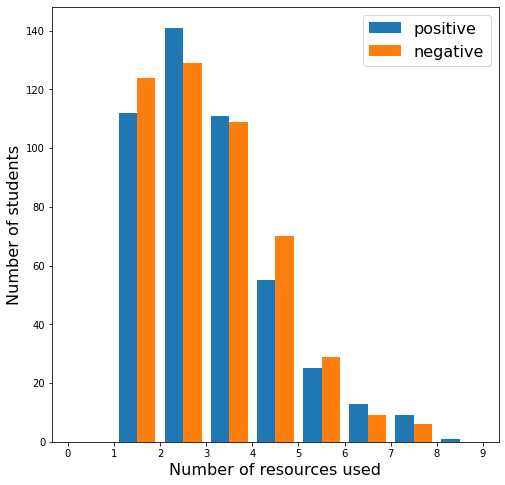

In [10]:
classes = ['positive', 'negative']
fig, ax = plt.subplots(figsize = (8,8))
sentiment_resource_counts = [list(q1_results[q1_results['sentiment'] == label]['resource count']) for label in classes]
bins = range(10)
arr = ax.hist(sentiment_resource_counts, bins, stacked=False, density=False, label = classes)
ax.legend(prop={'size': 16})
ax.set_xlabel('Number of resources used', size = 16)
ax.set_xticks(range(10))
ax.set_ylabel('Number of students', size = 16)

(array([  0., 631., 546., 421., 227.,  96.,  38.,  24.,   2.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

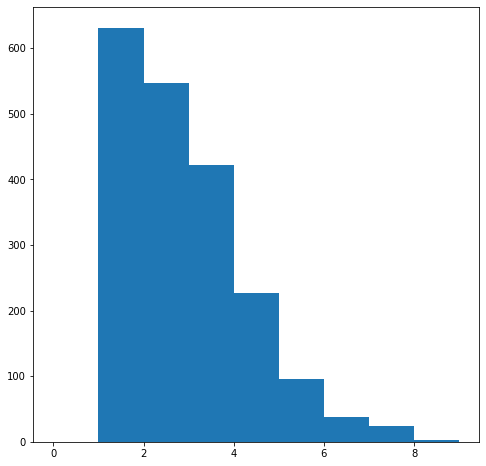

In [11]:
plt.figure(figsize = (8,8))
plt.hist(list(q1_results['resource count']), bins = range(10))

In [12]:
n = True

def normalize_array(a, axis=-1, order=2):
    l1 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l1[l1==0] = 1
    return a / np.expand_dims(l1, axis)

def get_problem_resource_counts(results, normalize = False):
    problem_resource_counts = []
    for problem in PROBLEMS:
        problem_count = []
        for resource in resource_answers:
            resource_results['good'] = results.apply(lambda x: resource in x['Answer'].split(', ') and x['Problem'] == problem, axis = 1)
            count = results[resource_results['good']].shape[0]/results[resource_results['Problem'] == problem].shape[0] if normalize else results[resource_results['good']].shape[0]
            problem_count.append(count)
        problem_resource_counts.append(problem_count)
    return pd.DataFrame(np.array(problem_resource_counts), columns = resource_answers, index = PROBLEMS)

problem_resource_df = get_problem_resource_counts(resource_results, normalize = n)
problem_resource_df

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Videos from this course,Videos from outside this course,Discussion thread from this course,Discussion thread from outside this course,Previous exercises from this course,Exercises from outside this course,Previous knowledge/skills from another programming language,OTHER
fex1,0.791667,0.169271,0.244792,0.031250,0.226562,0.184896,0.437500,0.085938
fex2,0.830295,0.138850,0.246844,0.113604,0.352034,0.183731,0.291725,0.088359
fex4,0.856942,0.110799,0.196353,0.047686,0.399719,0.131837,0.263675,0.078541
ps1,0.716690,0.196353,0.215989,0.081346,0.510519,0.225806,0.398317,0.077139
ps2,0.831933,0.218487,0.379552,0.154062,0.558824,0.173669,0.341737,0.102241
ps4,0.861789,0.227642,0.338753,0.176152,0.514905,0.249322,0.349593,0.065041


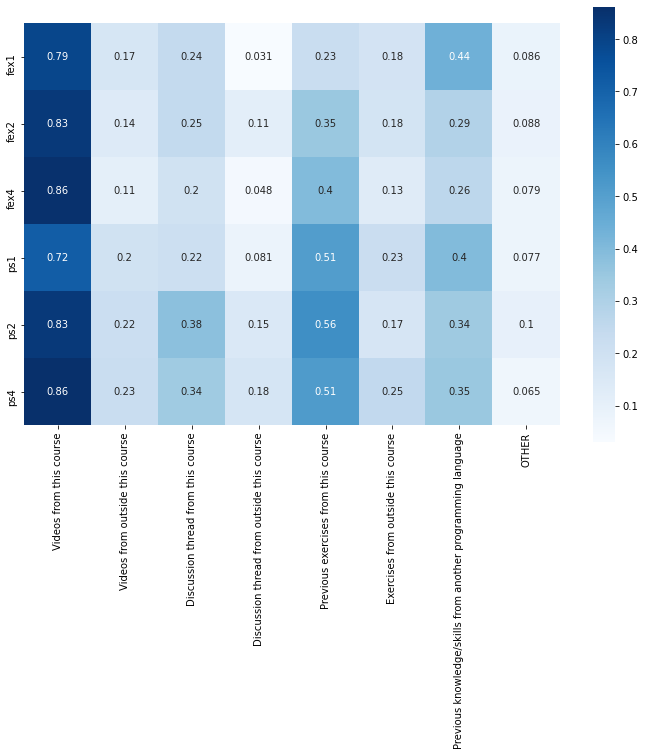

In [13]:
fig, ax = plt.subplots(figsize = (12,8))
fmt = '.2g' if n else 'd'
sns.heatmap(problem_resource_df, cmap=plt.cm.Blues, ax = ax, square = True, annot = True, fmt = fmt)

In [14]:
challenge_results = complete_results[complete_results['Question'] == challenge_question]
def get_challenge(row):
    username = row['username']
    problem = row['Problem']
    challenge_prediction = challenge_results[(challenge_results['username'] == username) & (challenge_results['Problem'] == problem)]['Answer']
    assert len(challenge_prediction) < 2
    if len(challenge_prediction) == 0:
        return 'none'
    return challenge_prediction.iloc[0]

q1_results['challenge'] = q1_results.apply(get_challenge, axis = 1)
q1_results['challenge score'] = q1_results['challenge'].apply(lambda x: challenge_responses.index(x))

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [15]:
def spearmanr_challenge_resource_count(results):
    return spearmanr(list(results['challenge score']), list(results['resource count']))
spearmanr_challenge_resource_count(q1_results)

SpearmanrResult(correlation=0.11262532838169874, pvalue=4.88726357892712e-07)

In [16]:
n = True

def get_challenge_resource_counts(results, normalize = False):
    challenge_resource_counts = []
    for challenge_response in challenge_responses:
        challenge_count = []
        for k in range(1, 9):
            results['good'] = results.apply(lambda x: x['resource count'] == k and x['challenge'] == challenge_response, axis = 1)
            count = results[results['good']].shape[0]/results[results['challenge'] == challenge_response].shape[0] if normalize else results[results['good']].shape[0]
            challenge_count.append(count)
        challenge_resource_counts.append(challenge_count)
    return pd.DataFrame(np.array(challenge_resource_counts), columns = range(1, 9), index = challenge_responses)

challenge_resource_df = get_challenge_resource_counts(q1_results, normalize = n)
challenge_resource_df

/yw_data/robert_gold/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,1,2,3,4,5,6,7,8
Not at all challenging,0.436464,0.270718,0.154696,0.104972,0.016575,0.011050,0.005525,0.000000
Slightly challenging,0.315166,0.291469,0.232227,0.099526,0.037915,0.016588,0.007109,0.000000
Moderately challenging,0.319652,0.297264,0.211443,0.095771,0.043532,0.022388,0.008706,0.001244
Very challenging,0.268585,0.247002,0.242206,0.151079,0.062350,0.014388,0.014388,0.000000
Extremely challenging/,0.310559,0.198758,0.149068,0.161491,0.099379,0.031056,0.043478,0.006211


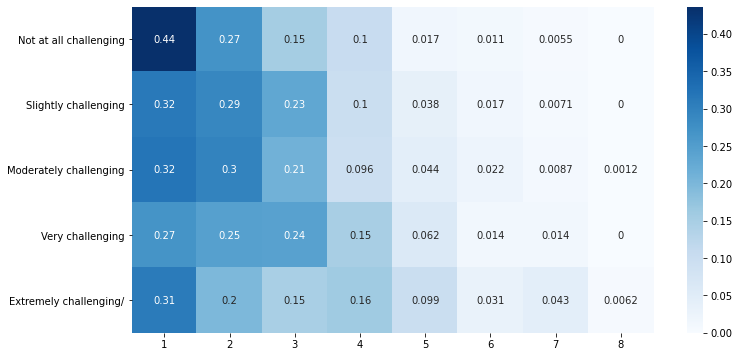

In [17]:
fig, ax = plt.subplots(figsize = (12,6))
fmt = '.2g' if n else 'd'
sns.heatmap(challenge_resource_df, cmap=plt.cm.Blues, ax = ax, square = True, annot = True, fmt = fmt)